# Experiment 13 N-Beats

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 115.0 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip walmart-recruiting-store-sales-forecasting.zip
!unzip train.csv.zip
!unzip features.csv.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 503MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  features.csv.zip
  inflating: features.csv            


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import time
import os
import joblib

# Core libraries
import wandb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep learning libraries
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    TORCH_AVAILABLE = True
    print("✅ PyTorch is available")
    print(f"   🔥 PyTorch version: {torch.__version__}")
    print(f"   🧠 CUDA available: {torch.cuda.is_available()}")
except ImportError as e:
    TORCH_AVAILABLE = False
    print("❌ PyTorch not available. Please install with:")
    print("   pip install torch torchvision torchaudio")
    print(f"   Import error: {e}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)



✅ PyTorch is available
   🔥 PyTorch version: 2.6.0+cu124
   🧠 CUDA available: True


In [4]:
!pip install timesfm torch mlflow dagshub scikit-learn pandas numpy matplotlib seaborn joblib -q wandb torch torchvision torchaudio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [38]:
class WalmartPreprocessingPipeline:
    """
    Preprocessing pipeline for Walmart sales data
    Same as used in TimesFM experiments (exp_11, exp_12)
    """

    def __init__(self):
        self.fitted = False
        self.outlier_thresholds = None
        self.train_data_for_lags = None

    def load_and_prepare_data(self):
        """Load and prepare raw data"""
        print("📂 Loading Walmart sales data...")

        try:
            # Load main datasets (from current directory, not data/ subdirectory)
            train = pd.read_csv('train.csv')
            stores = pd.read_csv('stores.csv')
            features = pd.read_csv('features.csv')

            print(f"   📊 Train data: {train.shape}")
            print(f"   🏪 Stores data: {stores.shape}")
            print(f"   🎯 Features data: {features.shape}")

            # Parse dates
            train['Date'] = pd.to_datetime(train['Date'])
            features['Date'] = pd.to_datetime(features['Date'])

            # Merge datasets
            train_merged = train.merge(stores, on='Store', how='left')
            train_full = train_merged.merge(features, on=['Store', 'Date'], how='left')

            print(f"   ✅ Merged data: {train_full.shape}")
            return train_full

        except FileNotFoundError as e:
            print(f"❌ Error loading data: {e}")
            print("Please ensure data files are in the current directory")
            raise

    def clean_merged_data(self, train_full):
        """Clean the merged dataset"""
        print("🧹 Cleaning merged data...")

        initial_len = len(train_full)

        # Handle duplicate IsHoliday columns if they exist
        if 'IsHoliday_x' in train_full.columns and 'IsHoliday_y' in train_full.columns:
            print("   🔄 Resolving duplicate IsHoliday columns...")
            train_full['IsHoliday'] = train_full['IsHoliday_x'] | train_full['IsHoliday_y']
            train_full = train_full.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)

        # Remove rows with missing Store or Dept
        train_full = train_full.dropna(subset=['Store', 'Dept'])

        # Fill missing values
        numeric_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
        for col in numeric_cols:
            if col in train_full.columns:
                train_full[col] = train_full[col].fillna(train_full[col].median())

        # Fill missing MarkDown columns with 0
        markdown_cols = [col for col in train_full.columns if 'MarkDown' in col]
        for col in markdown_cols:
            train_full[col] = train_full[col].fillna(0)

        final_len = len(train_full)
        print(f"   📊 Cleaned: {initial_len:,} → {final_len:,} rows")

        return train_full

    def create_temporal_split(self, df, train_ratio=0.8):
        """Create temporal train/validation split"""
        print("📅 Creating temporal split...")

        df_sorted = df.sort_values('Date')

        # Find split date
        unique_dates = df_sorted['Date'].unique()
        split_idx = int(len(unique_dates) * train_ratio)
        split_date = unique_dates[split_idx]

        # Split data
        train_data = df_sorted[df_sorted['Date'] < split_date].copy()
        val_data = df_sorted[df_sorted['Date'] >= split_date].copy()

        split_info = {
            'split_date': split_date,
            'train_date_range': (train_data['Date'].min(), train_data['Date'].max()),
            'val_date_range': (val_data['Date'].min(), val_data['Date'].max()),
            'train_weeks': len(train_data['Date'].unique()),
            'val_weeks': len(val_data['Date'].unique())
        }

        print(f"   📊 Train: {len(train_data):,} samples ({split_info['train_weeks']} weeks)")
        print(f"   📊 Validation: {len(val_data):,} samples ({split_info['val_weeks']} weeks)")
        print(f"   📅 Split date: {split_date}")

        return train_data, val_data, split_info

    def fit(self, train_data):
        """Fit the preprocessing pipeline on training data"""
        print("🔧 Fitting preprocessing pipeline on training data...")

        # Store training data for lag feature creation
        self.train_data_for_lags = train_data.copy()

        # Fit outlier removal thresholds on training data only
        self.outlier_thresholds = {
            'A': {'lower': -1000, 'upper': 50000},  # Type A stores
            'B': {'lower': -500, 'upper': 25000},   # Type B stores
            'C': {'lower': -200, 'upper': 15000}    # Type C stores
        }

        print("✅ Pipeline fitted on training data")
        self.fitted = True
        return self

    def transform(self, data, is_validation=False):
        """Transform data using fitted pipeline"""
        if not self.fitted:
            raise ValueError("Pipeline must be fitted before transform!")

        print(f"🔄 Transforming {'validation' if is_validation else 'training'} data...")

        df = data.copy()

        # Step 1: Create date features
        df = self._create_date_features(df)

        # Step 2: Create holiday features
        df = self._create_holiday_features(df)

        # Step 3: Encode categorical features (BEFORE outlier removal!)
        df = self._encode_categorical_features(df)

        # Step 4: Remove outliers (only on training data, AFTER encoding)
        if not is_validation:
            df = self._remove_outliers(df)

        # Step 5: Remove markdown features
        df = self._remove_markdown_features(df)

        # Step 6: Remove redundant features
        df = self._remove_redundant_features(df)

        print(f"✅ Transform complete. Shape: {df.shape}")
        return df

    def fit_transform(self, train_data):
        """Fit and transform training data in one step"""
        return self.fit(train_data).transform(train_data, is_validation=False)

    def _create_date_features(self, df):
        """Create date features"""
        df = df.copy()
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['WeekOfYear'] = df['Date'].dt.isocalendar().week
        df['Quarter'] = df['Date'].dt.quarter
        df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
        df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
        df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
        df['IsQuarterStart'] = df['Date'].dt.is_quarter_start.astype(int)
        df['IsQuarterEnd'] = df['Date'].dt.is_quarter_end.astype(int)
        start_date = df['Date'].min()
        df['DaysFromStart'] = (df['Date'] - start_date).dt.days
        df['WeeksFromStart'] = df['DaysFromStart'] // 7
        return df

    def _create_holiday_features(self, df):
        """Create holiday features"""
        df = df.copy()
        super_bowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10']
        labor_day_dates = ['2010-09-10', '2011-09-09', '2012-09-07']
        thanksgiving_dates = ['2010-11-26', '2011-11-25', '2012-11-23']
        christmas_dates = ['2010-12-31', '2011-12-30', '2012-12-28']

        df['IsSuperBowl'] = df['Date'].dt.strftime('%Y-%m-%d').isin(super_bowl_dates).astype(int)
        df['IsLaborDay'] = df['Date'].dt.strftime('%Y-%m-%d').isin(labor_day_dates).astype(int)
        df['IsThanksgiving'] = df['Date'].dt.strftime('%Y-%m-%d').isin(thanksgiving_dates).astype(int)
        df['IsChristmas'] = df['Date'].dt.strftime('%Y-%m-%d').isin(christmas_dates).astype(int)
        return df

    def _remove_outliers(self, df):
        """Remove outliers from training data"""
        initial_count = len(df)

        for store_type in ['A', 'B', 'C']:
            mask = df['Type'] == store_type
            if mask.sum() > 0:
                thresholds = self.outlier_thresholds[store_type]
                outlier_mask = (
                    (df['Weekly_Sales'] < thresholds['lower']) |
                    (df['Weekly_Sales'] > thresholds['upper'])
                )
                df = df[~(mask & outlier_mask)]

        removed_count = initial_count - len(df)
        print(f"   🧹 Removed {removed_count:,} outliers ({removed_count/initial_count*100:.1f}%)")
        return df

    def _remove_markdown_features(self, df):
        """Remove markdown features"""
        markdown_cols = [col for col in df.columns if 'MarkDown' in col]
        if markdown_cols:
            df = df.drop(markdown_cols, axis=1)
            print(f"   📝 Removed {len(markdown_cols)} markdown features")
        return df

    def _remove_redundant_features(self, df):
        """Remove redundant features"""
        redundant_cols = ['Fuel_Price', 'CPI', 'Unemployment']
        existing_redundant = [col for col in redundant_cols if col in df.columns]
        if existing_redundant:
            df = df.drop(existing_redundant, axis=1)
            print(f"   🔄 Removed {len(existing_redundant)} redundant features")
        return df

    def _encode_categorical_features(self, df):
        """Encode categorical features"""
        df = df.copy()

        # Encode Type (A=0, B=1, C=2)
        if 'Type' in df.columns:
            type_mapping = {'A': 0, 'B': 1, 'C': 2}
            df['Type_Encoded'] = df['Type'].map(type_mapping)

        return df


In [39]:
class TimeSeriesDataset(Dataset):
    """PyTorch Dataset for time series data"""

    def __init__(self, sequences, targets, covariates=None):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        self.covariates = torch.FloatTensor(covariates) if covariates is not None else None

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if self.covariates is not None:
            return self.sequences[idx], self.targets[idx], self.covariates[idx]
        else:
            return self.sequences[idx], self.targets[idx]


In [40]:
class NBeatsBlock(nn.Module):
    """N-BEATS block implementation"""

    def __init__(self, input_size, theta_size, basis_function, layers, layer_size):
        super().__init__()

        self.input_size = input_size
        self.theta_size = theta_size
        self.basis_function = basis_function

        # Fully connected layers
        layers_list = []
        layers_list.append(nn.Linear(input_size, layer_size))
        layers_list.append(nn.ReLU())

        for _ in range(layers - 1):
            layers_list.append(nn.Linear(layer_size, layer_size))
            layers_list.append(nn.ReLU())

        self.layers = nn.Sequential(*layers_list)

        # Theta layers for backcast and forecast
        self.backcast_theta = nn.Linear(layer_size, theta_size)
        self.forecast_theta = nn.Linear(layer_size, theta_size)

    def forward(self, x):
        x = self.layers(x)

        backcast_theta = self.backcast_theta(x)
        forecast_theta = self.forecast_theta(x)

        backcast = self.basis_function(backcast_theta, self.input_size, is_forecast=False)
        forecast = self.basis_function(forecast_theta, self.input_size, is_forecast=True)

        return backcast, forecast


In [41]:
class GenericBasis(nn.Module):
    """Generic basis function for N-BEATS"""

    def __init__(self, backcast_size, forecast_size):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, input_size, is_forecast=False):
        if is_forecast:
            # For forecast, use the forecast_size
            return theta[:, :self.forecast_size]
        else:
            # For backcast, use the input_size (lookback window)
            return theta[:, :input_size]



In [42]:
class TrendBasis(nn.Module):
    """Trend basis function for interpretable N-BEATS"""

    def __init__(self, degree_polynomial, backcast_size, forecast_size):
        super().__init__()
        self.degree_polynomial = degree_polynomial
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

        # Create polynomial basis
        self.backcast_basis = self._create_basis(backcast_size)
        self.forecast_basis = self._create_basis(forecast_size)

    def _create_basis(self, size):
        basis = torch.zeros(size, self.degree_polynomial + 1)
        for i in range(self.degree_polynomial + 1):
            basis[:, i] = torch.arange(size, dtype=torch.float) ** i
        return basis

    def forward(self, theta, input_size, is_forecast=False):
        if is_forecast:
            basis = self.forecast_basis.to(theta.device)
            return torch.matmul(theta[:, :self.degree_polynomial + 1], basis.T)
        else:
            basis = self.backcast_basis[:input_size].to(theta.device)
            return torch.matmul(theta[:, :self.degree_polynomial + 1], basis.T)


In [43]:
class SeasonalBasis(nn.Module):
    """Seasonal basis function for interpretable N-BEATS"""

    def __init__(self, harmonics, backcast_size, forecast_size):
        super().__init__()
        self.harmonics = harmonics
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

        # Create seasonal basis
        self.backcast_basis = self._create_basis(backcast_size)
        self.forecast_basis = self._create_basis(forecast_size)

    def _create_basis(self, size):
        basis = torch.zeros(size, 2 * self.harmonics)
        for i in range(self.harmonics):
            basis[:, 2*i] = torch.cos(2 * np.pi * (i + 1) * torch.arange(size, dtype=torch.float) / size)
            basis[:, 2*i + 1] = torch.sin(2 * np.pi * (i + 1) * torch.arange(size, dtype=torch.float) / size)
        return basis

    def forward(self, theta, input_size, is_forecast=False):
        if is_forecast:
            basis = self.forecast_basis.to(theta.device)
            return torch.matmul(theta[:, :2 * self.harmonics], basis.T)
        else:
            basis = self.backcast_basis[:input_size].to(theta.device)
            return torch.matmul(theta[:, :2 * self.harmonics], basis.T)


In [44]:
class NBeatsModel(nn.Module):
    """N-BEATS model implementation"""

    def __init__(self,
                 input_size=52,  # Lookback window (weeks)
                 output_size=12,  # Forecast horizon (weeks)
                 stacks=2,
                 blocks_per_stack=3,
                 layers=4,
                 layer_size=512,
                 basis_type='generic',  # 'generic' or 'interpretable'
                 degree_polynomial=3,
                 harmonics=1):
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.stacks = stacks
        self.blocks_per_stack = blocks_per_stack

        # Create basis functions
        if basis_type == 'generic':
            basis_function = GenericBasis(input_size, output_size)
            theta_size = max(input_size, output_size)
        elif basis_type == 'interpretable':
            # For interpretable model, we'll use trend and seasonal stacks
            if stacks != 2:
                print("Warning: Interpretable model works best with 2 stacks (trend + seasonal)")

            self.trend_basis = TrendBasis(degree_polynomial, input_size, output_size)
            self.seasonal_basis = SeasonalBasis(harmonics, input_size, output_size)
            theta_size = max(degree_polynomial + 1, 2 * harmonics)
        else:
            raise ValueError("basis_type must be 'generic' or 'interpretable'")

        self.basis_type = basis_type

        # Create stacks of blocks
        self.stacks_list = nn.ModuleList()

        for stack_id in range(stacks):
            stack = nn.ModuleList()

            for block_id in range(blocks_per_stack):
                if basis_type == 'interpretable':
                    if stack_id == 0:  # Trend stack
                        block = NBeatsBlock(input_size, theta_size, self.trend_basis, layers, layer_size)
                    else:  # Seasonal stack
                        block = NBeatsBlock(input_size, theta_size, self.seasonal_basis, layers, layer_size)
                else:  # Generic
                    block = NBeatsBlock(input_size, theta_size, basis_function, layers, layer_size)

                stack.append(block)

            self.stacks_list.append(stack)

    def forward(self, x):
        batch_size = x.shape[0]
        forecast = torch.zeros(batch_size, self.output_size, device=x.device)

        # Residual connection through stacks
        residual = x

        for stack in self.stacks_list:
            stack_forecast = torch.zeros(batch_size, self.output_size, device=x.device)

            for block in stack:
                backcast, block_forecast = block(residual)
                residual = residual - backcast
                stack_forecast = stack_forecast + block_forecast

            forecast = forecast + stack_forecast

        return forecast



In [45]:
def setup_wandb(project_name="walmart-nbeats-forecasting"):
    """Setup Weights & Biases tracking"""
    print("🔧 Setting up Weights & Biases...")

    # Initialize wandb
    try:
        wandb.init(
            project=project_name,
            name=f"nbeats_experiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
            config={
                "model_type": "N-BEATS",
                "dataset": "Walmart_Sales",
                "framework": "PyTorch",
                "feature_engineering": "Advanced_Pipeline"
            }
        )
        print(f"✅ Wandb initialized successfully!")
        print(f"🔗 Dashboard: {wandb.run.url}")

    except Exception as e:
        print(f"⚠️ Wandb init warning: {e}")
        print("Continuing without wandb tracking...")
        return False

    return True



In [46]:
def calculate_wmae(y_true, y_pred, is_holiday, holiday_weight=5.0):
    """Calculate Weighted Mean Absolute Error (Competition Metric)"""
    weights = np.where(is_holiday, holiday_weight, 1.0)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)


In [47]:
def get_preprocessed_data():
    """Get preprocessed data using the pipeline"""
    print("📊 Getting preprocessed data...")

    # Initialize pipeline
    pipeline = WalmartPreprocessingPipeline()

    # Load and prepare data
    train_full = pipeline.load_and_prepare_data()
    train_full = pipeline.clean_merged_data(train_full)

    # Create temporal split
    train_data, val_data, split_info = pipeline.create_temporal_split(train_full)

    # Fit pipeline on training data
    pipeline.fit(train_data)

    # Transform both training and validation data
    train_processed = pipeline.transform(train_data, is_validation=False)
    val_processed = pipeline.transform(val_data, is_validation=True)

    # Prepare features and targets
    feature_columns = [col for col in train_processed.columns
                      if col not in ['Date', 'Weekly_Sales', 'Store', 'Dept', 'Type']]

    X_train = train_processed[feature_columns]
    y_train = train_processed['Weekly_Sales']
    X_val = val_processed[feature_columns]
    y_val = val_processed['Weekly_Sales']

    # Get holiday information
    train_holidays = train_processed['IsHoliday']
    val_holidays = val_processed['IsHoliday']

    print(f"✅ Data preprocessing complete!")
    print(f"   📈 Training: {len(X_train):,} samples, {len(feature_columns)} features")
    print(f"   📉 Validation: {len(X_val):,} samples")

    return (X_train, y_train, X_val, y_val, train_holidays, val_holidays,
            split_info, feature_columns, train_processed, val_processed)



In [48]:
def prepare_nbeats_data(train_processed, val_processed, lookback=52, horizon=12, max_models=None):
    """Prepare time series data for N-BEATS training"""
    print("🚀 Preparing N-BEATS time series data...")

    # Get unique Store-Dept combinations
    train_combinations = set(zip(train_processed['Store'], train_processed['Dept']))
    val_combinations = set(zip(val_processed['Store'], val_processed['Dept']))
    common_combinations = list(train_combinations & val_combinations)

    if max_models:
        # Limit to top combinations by data volume
        combo_stats = []
        for store, dept in common_combinations:
            train_data = train_processed[
                (train_processed['Store'] == store) &
                (train_processed['Dept'] == dept)
            ]
            combo_stats.append((store, dept, len(train_data)))

        combo_stats.sort(key=lambda x: x[2], reverse=True)
        common_combinations = [(store, dept) for store, dept, _ in combo_stats[:max_models]]
        print(f"   🔧 Limited to {max_models} Store-Dept combinations")

    print(f"   🎯 Processing {len(common_combinations):,} Store-Dept combinations")

    # Prepare time series sequences
    all_sequences = []
    all_targets = []
    all_covariates = []
    combination_info = []

    successful_models = 0
    skipped_models = 0

    for store, dept in common_combinations:
        try:
            # Get train data for this combination
            train_data = train_processed[
                (train_processed['Store'] == store) &
                (train_processed['Dept'] == dept)
            ].sort_values('Date')

            # Get val data for this combination
            val_data = val_processed[
                (val_processed['Store'] == store) &
                (val_processed['Dept'] == dept)
            ].sort_values('Date')

            if len(train_data) < lookback + horizon or len(val_data) < horizon:
                skipped_models += 1
                continue

            # Extract sales series
            train_sales = train_data['Weekly_Sales'].values
            val_sales = val_data['Weekly_Sales'].values

            # Create sequences for training
            for i in range(len(train_sales) - lookback - horizon + 1):
                sequence = train_sales[i:i + lookback]
                target = train_sales[i + lookback:i + lookback + horizon]

                # Normalize sequence
                seq_mean = sequence.mean()
                seq_std = sequence.std()
                if seq_std > 0:
                    normalized_sequence = (sequence - seq_mean) / seq_std
                    normalized_target = (target - seq_mean) / seq_std
                else:
                    normalized_sequence = sequence
                    normalized_target = target

                all_sequences.append(normalized_sequence)
                all_targets.append(normalized_target)

                # Covariates (store info)
                covariates = [
                    train_data['Type_Encoded'].iloc[0] if 'Type_Encoded' in train_data.columns else 0,
                    train_data['Size'].iloc[0] if 'Size' in train_data.columns else 0,
                    store,
                    dept
                ]
                all_covariates.append(covariates)

            # Store combination info for validation
            combination_info.append({
                'store': store,
                'dept': dept,
                'train_mean': train_sales.mean(),
                'train_std': train_sales.std(),
                'val_data': val_sales
            })

            successful_models += 1

        except Exception as e:
            print(f"   ⚠️ Error processing Store {store}, Dept {dept}: {e}")
            skipped_models += 1
            continue

    print(f"✅ Data preparation complete!")
    print(f"   ✅ Successful: {successful_models}")
    print(f"   ⚠️ Skipped: {skipped_models}")
    print(f"   📊 Total sequences: {len(all_sequences):,}")

    return (np.array(all_sequences), np.array(all_targets), np.array(all_covariates),
            combination_info, common_combinations)



In [49]:
def train_nbeats_model(sequences, targets, covariates, config, device='cpu'):
    """Train N-BEATS model"""
    print("🚀 Training N-BEATS model...")

    # Create dataset and dataloader
    dataset = TimeSeriesDataset(sequences, targets, covariates)

    # Split into train/val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    # Initialize model
    model = NBeatsModel(
        input_size=config['lookback'],
        output_size=config['horizon'],
        stacks=config['stacks'],
        blocks_per_stack=config['blocks_per_stack'],
        layers=config['layers'],
        layer_size=config['layer_size'],
        basis_type=config['basis_type']
    ).to(device)

    # Optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(config['epochs']):
        # Training
        model.train()
        epoch_train_loss = 0

        for batch in train_loader:
            if len(batch) == 3:
                seq, target, cov = batch
            else:
                seq, target = batch

            seq, target = seq.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Validation
        model.eval()
        epoch_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    seq, target, cov = batch
                else:
                    seq, target = batch

                seq, target = seq.to(device), target.to(device)
                output = model(seq)
                loss = criterion(output, target)
                epoch_val_loss += loss.item()

        # Calculate average losses
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        # Log to wandb
        if wandb.run:
            wandb.log({
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'learning_rate': optimizer.param_groups[0]['lr']
            })

        if epoch % 20 == 0:
            print(f"   Epoch {epoch:3d}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

    # Load best model
    model.load_state_dict(best_model_state)

    print(f"✅ Training complete! Best validation loss: {best_val_loss:.6f}")

    return model, train_losses, val_losses


In [55]:
def make_nbeats_predictions(model, combination_info, val_processed, lookback=52, horizon=12, device='cpu'):
    """Make predictions using trained N-BEATS model"""
    print("🔮 Making N-BEATS predictions...")

    model.eval()
    all_predictions = []
    all_actuals = []
    all_holidays = []

    successful_predictions = 0
    skipped_predictions = 0

    with torch.no_grad():
        for combo in combination_info:
            try:
                store = combo['store']
                dept = combo['dept']

                # Get validation data for this Store-Dept combination
                val_data_subset = val_processed[
                    (val_processed['Store'] == store) &
                    (val_processed['Dept'] == dept)
                ].sort_values('Date')

                if len(val_data_subset) < horizon:
                    skipped_predictions += 1
                    continue

                val_sales = val_data_subset['Weekly_Sales'].values
                val_holidays = val_data_subset['IsHoliday'].values

                # Strategy: Use the first part of validation as input, predict the rest
                # If validation data is shorter than lookback, use what we have
                available_weeks = len(val_sales)

                if available_weeks >= lookback + horizon:
                    # Ideal case: enough data for full lookback + horizon
                    input_sequence = val_sales[:lookback]
                    target_sequence = val_sales[lookback:lookback + horizon]
                    target_holidays = val_holidays[lookback:lookback + horizon]
                elif available_weeks >= horizon * 2:
                    # Use first half as input, second half as target
                    split_point = available_weeks // 2
                    input_sequence = val_sales[:split_point]
                    target_sequence = val_sales[split_point:split_point + horizon]
                    target_holidays = val_holidays[split_point:split_point + horizon]
                elif available_weeks >= horizon:
                    # Use first few weeks as input, rest as target
                    input_weeks = max(4, available_weeks - horizon)  # At least 4 weeks input
                    input_sequence = val_sales[:input_weeks]
                    target_sequence = val_sales[input_weeks:input_weeks + horizon]
                    target_holidays = val_holidays[input_weeks:input_weeks + horizon]
                else:
                    skipped_predictions += 1
                    continue

                # Pad input sequence if shorter than expected model input
                if len(input_sequence) < lookback:
                    # Pad with the mean of the sequence
                    pad_length = lookback - len(input_sequence)
                    pad_value = input_sequence.mean()
                    input_sequence = np.concatenate([np.full(pad_length, pad_value), input_sequence])
                elif len(input_sequence) > lookback:
                    # Truncate to lookback length
                    input_sequence = input_sequence[-lookback:]

                # Normalize input using training statistics
                seq_mean = combo['train_mean']
                seq_std = combo['train_std']

                if seq_std > 0:
                    normalized_input = (input_sequence - seq_mean) / seq_std
                else:
                    normalized_input = input_sequence

                # Make prediction
                input_tensor = torch.FloatTensor(normalized_input).unsqueeze(0).to(device)
                pred_normalized = model(input_tensor).cpu().numpy().flatten()

                # Only use the first len(target_sequence) predictions
                pred_normalized = pred_normalized[:len(target_sequence)]

                # Denormalize prediction
                if seq_std > 0:
                    prediction = pred_normalized * seq_std + seq_mean
                else:
                    prediction = pred_normalized

                # Ensure positive sales
                prediction = np.maximum(prediction, 0)

                # Add to results
                all_predictions.extend(prediction)
                all_actuals.extend(target_sequence)
                all_holidays.extend(target_holidays)

                successful_predictions += 1

            except Exception as e:
                print(f"   ⚠️ Error predicting for Store {store}, Dept {dept}: {e}")
                skipped_predictions += 1
                continue

    print(f"✅ Predictions complete!")
    print(f"   ✅ Successful: {successful_predictions}")
    print(f"   ⚠️ Skipped: {skipped_predictions}")
    print(f"   📊 Generated {len(all_predictions):,} forecasts")

    return np.array(all_predictions), np.array(all_actuals), np.array(all_holidays)


In [56]:
def evaluate_model(y_true, y_pred, is_holiday):
    """Evaluate model performance"""
    print("📊 Evaluating model performance...")

    # Check if we have any predictions
    if len(y_true) == 0 or len(y_pred) == 0:
        print("⚠️ No predictions available for evaluation!")
        return {
            'WMAE': 0,
            'MAE': 0,
            'RMSE': 0,
            'R²': 0,
            'Holiday_MAE': 0,
            'Non_Holiday_MAE': 0,
            'Holiday_WMAE': 0,
            'Non_Holiday_WMAE': 0,
            'Holiday_Samples': 0,
            'Non_Holiday_Samples': 0,
            'Total_Samples': 0
        }

    # Basic metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Competition metric (WMAE)
    wmae = calculate_wmae(y_true, y_pred, is_holiday)

    # Calculate by holiday/non-holiday
    holiday_mask = is_holiday
    non_holiday_mask = ~is_holiday

    if holiday_mask.sum() > 0:
        holiday_mae = mean_absolute_error(y_true[holiday_mask], y_pred[holiday_mask])
        holiday_wmae = calculate_wmae(y_true[holiday_mask], y_pred[holiday_mask], is_holiday[holiday_mask])
    else:
        holiday_mae = 0
        holiday_wmae = 0

    if non_holiday_mask.sum() > 0:
        non_holiday_mae = mean_absolute_error(y_true[non_holiday_mask], y_pred[non_holiday_mask])
        non_holiday_wmae = calculate_wmae(y_true[non_holiday_mask], y_pred[non_holiday_mask], is_holiday[non_holiday_mask])
    else:
        non_holiday_mae = 0
        non_holiday_wmae = 0

    metrics = {
        'WMAE': wmae,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Holiday_MAE': holiday_mae,
        'Non_Holiday_MAE': non_holiday_mae,
        'Holiday_WMAE': holiday_wmae,
        'Non_Holiday_WMAE': non_holiday_wmae,
        'Holiday_Samples': holiday_mask.sum(),
        'Non_Holiday_Samples': non_holiday_mask.sum(),
        'Total_Samples': len(y_true)
    }

    print(f"✅ Evaluation complete!")
    print(f"   🎯 WMAE: ${wmae:,.2f}")
    print(f"   📊 MAE: ${mae:,.2f}")
    print(f"   📊 RMSE: ${rmse:,.2f}")
    print(f"   📊 R²: {r2:.4f}")
    print(f"   🎄 Holiday samples: {holiday_mask.sum():,}")
    print(f"   📅 Non-holiday samples: {non_holiday_mask.sum():,}")

    return metrics


In [57]:
def create_visualizations(y_true, y_pred, is_holiday, metrics):
    """Create visualization plots"""
    print("📈 Creating visualizations...")

    # Check if we have any data to visualize
    if len(y_true) == 0 or len(y_pred) == 0:
        print("⚠️ No data available for visualization - skipping plots")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('N-BEATS Model Performance Analysis', fontsize=16)

    # 1. Predictions vs Actuals
    axes[0, 0].scatter(y_true, y_pred, alpha=0.6, s=20)
    axes[0, 0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Sales')
    axes[0, 0].set_ylabel('Predicted Sales')
    axes[0, 0].set_title(f'Predictions vs Actuals (R² = {metrics["R²"]:.4f})')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Residuals
    residuals = y_pred - y_true
    axes[0, 1].scatter(y_pred, residuals, alpha=0.6, s=20)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Sales')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Holiday vs Non-Holiday Performance
    holiday_metrics = [metrics['Holiday_MAE'], metrics['Non_Holiday_MAE']]
    holiday_labels = ['Holiday', 'Non-Holiday']
    axes[1, 0].bar(holiday_labels, holiday_metrics, color=['red', 'blue'], alpha=0.7)
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].set_title('Holiday vs Non-Holiday Performance')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Error Distribution
    errors = np.abs(y_pred - y_true)
    axes[1, 1].hist(errors, bins=50, alpha=0.7, color='green')
    axes[1, 1].set_xlabel('Absolute Error')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(f'Error Distribution (MAE = ${metrics["MAE"]:,.2f})')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Save plot
    plt.savefig('nbeats_performance_analysis.png', dpi=300, bbox_inches='tight')

    # Log to wandb
    if wandb.run:
        wandb.log({"performance_analysis": wandb.Image(plt)})

    plt.show()

    print("✅ Visualizations complete!")


In [58]:
def main():
    """Main experiment execution"""
    print("🚀 Starting N-BEATS Experiment for Walmart Sales Forecasting")
    print("=" * 80)

    # Check PyTorch availability
    if not TORCH_AVAILABLE:
        print("❌ PyTorch is required for N-BEATS. Please install it first.")
        return

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🔧 Using device: {device}")

    # Setup wandb
    wandb_enabled = setup_wandb()

    start_time = time.time()

    try:
        # Configuration
        config = {
            'lookback': 52,  # 52 weeks lookback
            'horizon': 12,   # 12 weeks forecast
            'stacks': 2,
            'blocks_per_stack': 3,
            'layers': 4,
            'layer_size': 512,
            'basis_type': 'generic',  # 'generic' or 'interpretable'
            'batch_size': 32,
            'learning_rate': 1e-3,
            'epochs': 100,
            'max_models': 100  # Limit number of Store-Dept combinations
        }

        if wandb_enabled:
            wandb.config.update(config)

        # Step 1: Get preprocessed data
        print("\n📊 Step 1: Data preprocessing...")
        (X_train, y_train, X_val, y_val, train_holidays, val_holidays,
         split_info, feature_columns, train_processed, val_processed) = get_preprocessed_data()

        # Log data info
        if wandb_enabled:
            wandb.log({
                "train_samples": len(X_train),
                "val_samples": len(X_val),
                "total_features": len(feature_columns),
                "split_date": str(split_info['split_date'])
            })

        # Step 2: Prepare N-BEATS data
        print("\n🔄 Step 2: Preparing N-BEATS time series data...")
        (sequences, targets, covariates, combination_info,
         common_combinations) = prepare_nbeats_data(
            train_processed, val_processed,
            lookback=config['lookback'],
            horizon=config['horizon'],
            max_models=config['max_models']
        )

        # Log sequence info
        if wandb_enabled:
            wandb.log({
                "total_sequences": len(sequences),
                "store_dept_combinations": len(combination_info),
                "sequence_length": config['lookback'],
                "forecast_horizon": config['horizon']
            })

        # Step 3: Train N-BEATS model
        print("\n🤖 Step 3: Training N-BEATS model...")
        model, train_losses, val_losses = train_nbeats_model(
            sequences, targets, covariates, config, device
        )

        # Step 4: Make predictions
        print("\n🔮 Step 4: Making predictions...")
        y_pred, y_true, is_holiday = make_nbeats_predictions(
            model, combination_info, val_processed,
            lookback=config['lookback'],
            horizon=config['horizon'],
            device=device
        )

        # Step 5: Evaluate model
        print("\n📊 Step 5: Evaluating model...")
        metrics = evaluate_model(y_true, y_pred, is_holiday)

        # Log metrics to wandb
        if wandb_enabled:
            wandb.log(metrics)

        # Step 6: Create visualizations (only if we have predictions)
        if len(y_true) > 0 and len(y_pred) > 0:
            print("\n📈 Step 6: Creating visualizations...")
            create_visualizations(y_true, y_pred, is_holiday, metrics)
        else:
            print("\n⚠️ Step 6: Skipping visualizations - no predictions generated")
            print("   This might indicate that validation data is too short for the configured lookback/horizon")
            print(f"   Current config: lookback={config['lookback']}, horizon={config['horizon']}")
            print(f"   Validation weeks available: {split_info['val_weeks']}")
            print(f"   Required for prediction: {config['lookback'] + config['horizon']} weeks minimum")

        # Step 7: Save model
        print("\n💾 Step 7: Saving model...")
        model_path = f"nbeats_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': config,
            'metrics': metrics,
            'combination_info': combination_info
        }, model_path)
        print(f"   ✅ Model saved: {model_path}")

        # Final summary
        total_time = time.time() - start_time
        print(f"\n🎉 Experiment complete!")
        print(f"   ⏱️ Total time: {total_time:.2f} seconds")
        print(f"   🎯 Final WMAE: ${metrics['WMAE']:,.2f}")
        print(f"   📊 Final MAE: ${metrics['MAE']:,.2f}")
        print(f"   📊 Final R²: {metrics['R²']:.4f}")

        if wandb_enabled:
            wandb.log({
                "total_time_seconds": total_time,
                "final_wmae": metrics['WMAE'],
                "final_mae": metrics['MAE'],
                "final_r2": metrics['R²']
            })
            wandb.finish()

    except Exception as e:
        print(f"\n❌ Experiment failed: {e}")
        import traceback
        traceback.print_exc()

        if wandb_enabled:
            wandb.finish()

        raise


🚀 Starting N-BEATS Experiment for Walmart Sales Forecasting
🔧 Using device: cuda
🔧 Setting up Weights & Biases...


✅ Wandb initialized successfully!
🔗 Dashboard: https://wandb.ai/konstantine25b-free-university-of-tbilisi-/walmart-nbeats-forecasting/runs/wdkyvyvq

📊 Step 1: Data preprocessing...
📊 Getting preprocessed data...
📂 Loading Walmart sales data...
   📊 Train data: (421570, 5)
   🏪 Stores data: (45, 3)
   🎯 Features data: (8190, 12)
   ✅ Merged data: (421570, 17)
🧹 Cleaning merged data...
   🔄 Resolving duplicate IsHoliday columns...
   📊 Cleaned: 421,570 → 421,570 rows
📅 Creating temporal split...
   📊 Train: 335,761 samples (114 weeks)
   📊 Validation: 85,809 samples (29 weeks)
   📅 Split date: 2012-04-13 00:00:00
🔧 Fitting preprocessing pipeline on training data...
✅ Pipeline fitted on training data
🔄 Transforming training data...
   🧹 Removed 45,003 outliers (13.4%)
   📝 Removed 5 markdown features
   🔄 Removed 3 redundant features
✅ Transform complete. Shape: (290758, 26)
🔄 Transforming validation data...
   📝 Removed 5 markdown features
   🔄 Removed 3 redundant features
✅ Transform co

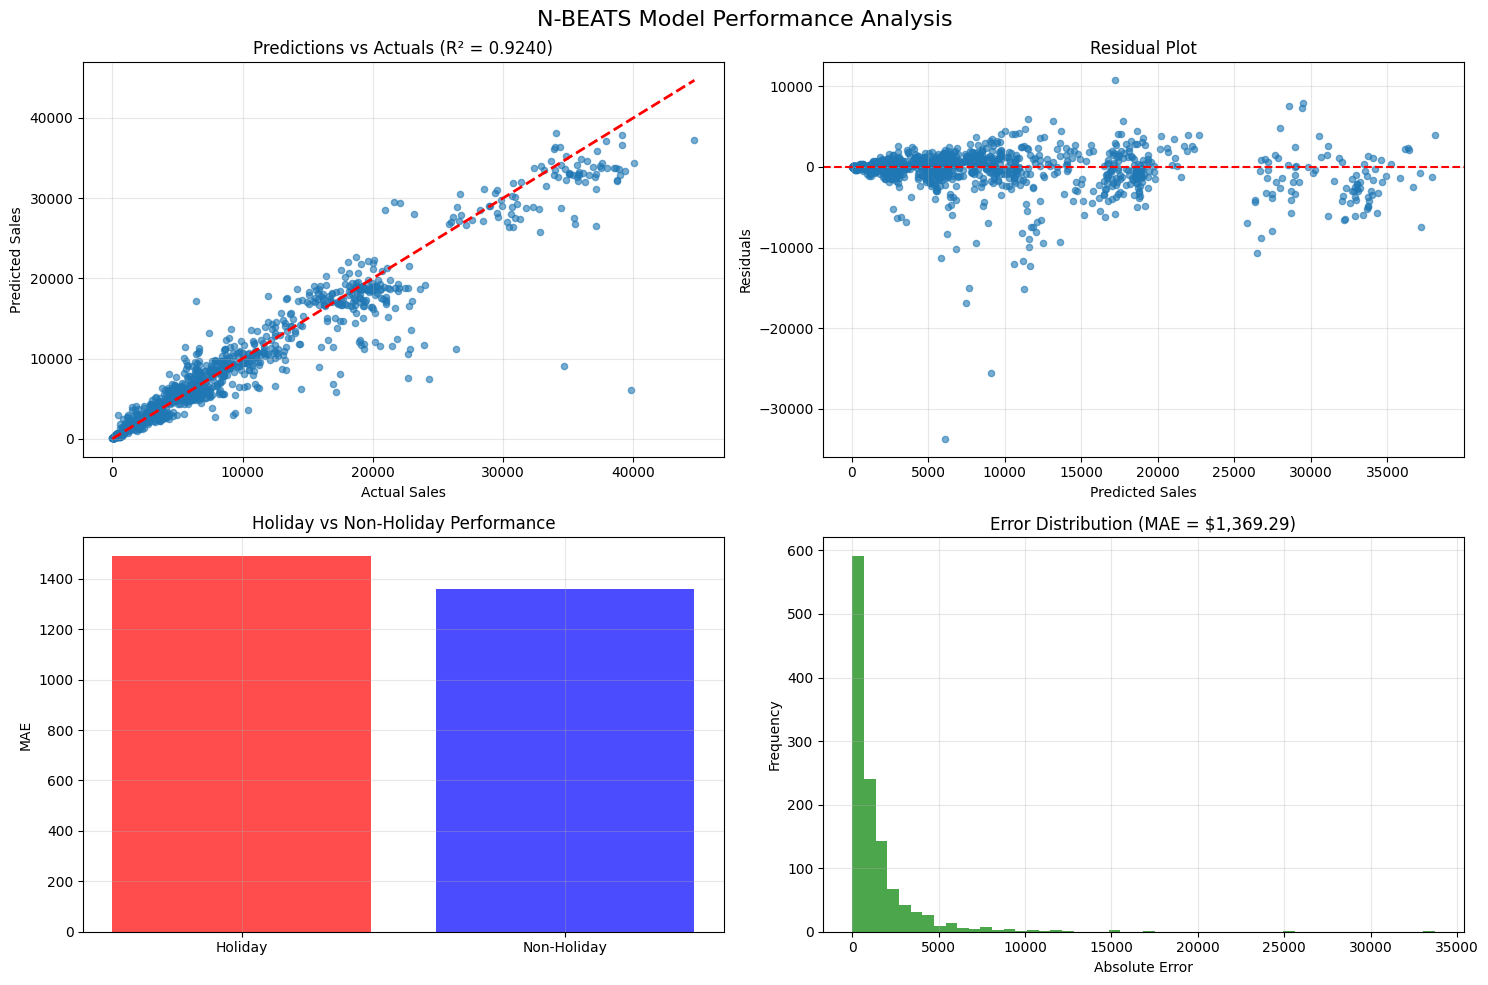

✅ Visualizations complete!

💾 Step 7: Saving model...
   ✅ Model saved: nbeats_model_20250711_123429.pth

🎉 Experiment complete!
   ⏱️ Total time: 166.01 seconds
   🎯 Final WMAE: $1,399.42
   📊 Final MAE: $1,369.29
   📊 Final R²: 0.9240


Holiday_MAE,▁
Holiday_Samples,▁
Holiday_WMAE,▁
MAE,▁
Non_Holiday_MAE,▁
Non_Holiday_Samples,▁
Non_Holiday_WMAE,▁
RMSE,▁
R²,▁
Total_Samples,▁
WMAE,▁


In [59]:
if __name__ == "__main__":
    main()